In [17]:
import glob
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

def load_labels(myDir):
    labels=[]
    fileList = glob.glob(myDir)
    for fname in fileList:
        fileName = os.path.basename(fname)
        curLabel = fileName.split("-")[0]
        labels.append(curLabel)
    return np.asarray(labels)
        

def load_data(myDir):
    fileList = glob.glob(myDir)    
    x = np.array([np.array(Image.open(fname)).flatten() for fname in fileList])
    x=x/255
    return x
    

#(X_train, y_train), (X_test, y_test) = mnist.load_data()

myDir ="train/*.png"
X_train = load_data(myDir)
Y_train = load_labels(myDir)


myDir2 ="eval/*.png"
X_test = load_data(myDir2)
Y_test = load_labels(myDir2)
X_train

myDir3 ="valid/*.png"
X_valid = load_data(myDir3)
Y_valid = load_labels(myDir3)

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
import numpy

In [19]:
# one hot encode outputs
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
Y_valid = np_utils.to_categorical(Y_valid)
num_classes = Y_test.shape[1]

In [20]:
print(Y_test.shape)
print(Y_train.shape)
print(Y_valid.shape)

print(X_test.shape)
print(X_train.shape)
print(X_valid.shape)


(21780, 10)
(7000, 10)
(7000, 10)
(21780, 784)
(7000, 784)
(7000, 784)


# Task 1: Convolutional Neural Network (CNN)

In [21]:
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D



In [22]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')
X_valid = X_valid.reshape((X_valid.shape[0], 28, 28, 1)).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

In [23]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(16, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
# build the model
model = baseline_model()
# Fit the model
cnn_history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=10, batch_size=16)
# Final evaluation of the model
cnn_scores = model.evaluate(X_test, Y_test, verbose=1)
print(".")
print("CNN Error: %.2f%%" % (100-cnn_scores[1]*100))
print("\n%s: %.2f%%" % (model.metrics_names[1], cnn_scores[1]*100))

Train on 7000 samples, validate on 7000 samples
Epoch 1/10
7000/7000 [==============================] - 18s 3ms/step - loss: 2.0103 - accuracy: 0.2554 - val_loss: 1.5161 - val_accuracy: 0.5000
Epoch 2/10
7000/7000 [==============================] - 15s 2ms/step - loss: 1.1392 - accuracy: 0.6214 - val_loss: 1.0745 - val_accuracy: 0.6469
Epoch 3/10
7000/7000 [==============================] - 15s 2ms/step - loss: 0.8815 - accuracy: 0.7071 - val_loss: 0.8813 - val_accuracy: 0.7307
Epoch 4/10
7000/7000 [==============================] - 15s 2ms/step - loss: 0.8016 - accuracy: 0.7367 - val_loss: 0.7619 - val_accuracy: 0.7621
Epoch 5/10
7000/7000 [==============================] - 15s 2ms/step - loss: 0.7519 - accuracy: 0.7540 - val_loss: 0.7444 - val_accuracy: 0.7749
Epoch 6/10
7000/7000 [==============================] - 15s 2ms/step - loss: 0.7130 - accuracy: 0.7680 - val_loss: 0.7276 - val_accuracy: 0.7727
Epoch 7/10
7000/7000 [==============================] - 14s 2ms/step - loss: 0.672

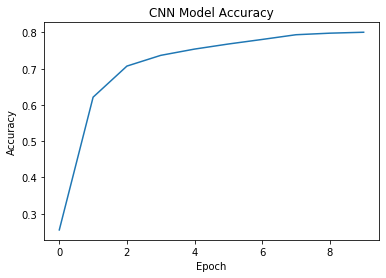

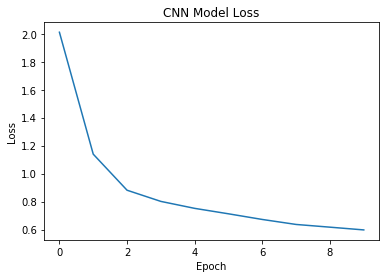

In [9]:
plt.plot(cnn_history.history['accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(cnn_history.history['loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Task 2: Transfer Learning using Pre-Trained ConvNets

# Fine Tuning

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
import cv2
from tensorflow.keras import Input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import numpy as np

In [11]:
vgg_conv = VGG16(weights=None, include_top=False, input_shape=(32,32,1))

In [12]:
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

In [13]:
# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

#Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
#  Error when checking input: expected vgg16_input to have shape (32, 32, 1) but got array with shape (28, 28, 1)
#so first we have to change the input layer dimension by 28x28 to minimum 32 x32

X_train = np.expand_dims(X_train, axis=0, shape=(32,32,1))
X_test = np.expand_dims(X_test, axis=0, shape=(32,32,1))
X_valid = np.expand_dims(X_valid, axis=0, shape=(32,32,1))

In [ ]:
transfer_history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=10, batch_size=10)
# Final evaluation of the model
transfer_scores = model.evaluate(X_test, Y_test, verbose=1)
print(".")
print("CNN Error: %.2f%%" % (100-transfer_scores[1]*100))
print("\n%s: %.2f%%" % (model.metrics_names[1], transfer_scores[1]*100))

Train on 7000 samples, validate on 7000 samples
Epoch 1/20
7000/7000 [==============================] - 17s 2ms/step - loss: 2.3033 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/step - loss: 2.3029 - accuracy: 0.0961 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/step - loss: 2.3030 - accuracy: 0.0953 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/step - loss: 2.3029 - accuracy: 0.0940 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/20
7000/7000 [==============================] - 15s 2ms/step - loss: 2.3029 - accuracy: 0.0927 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/20
6528/7000 [==========================>...] - ETA: 0s - loss: 2.3029 - accuracy: 0.0936

In [ ]:
plt.plot(transfer_history.history['accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(transfer_history.history['loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()